This code allows for the segmentation of a lidar scan (surface elevation), based off textural simularity, and also demonstrates how the segments can be used to extrapolate snow depth measurements

In [2]:
#import some modules
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import glob, cv2, os
from Data.gabor import *
from skimage.filters.rank import entropy
from skimage.morphology import disk
import Data.lmom as lmom
from itertools import chain, combinations
from argparse import Namespace
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.interpolate import griddata
from scipy.stats import hmean, gmean
import pandas as pd
import seaborn as sns

First, let's navigate to our demo directory. You may need to change this if you're running this locally

In [3]:
head = '/home/jeffrey/cryo-toolbox/textureseg_demo/'
os.chdir(head)

There are 3 sets of filenames - ls_txt is the snow depth data, ls_lidar is the lidar scans, ls_i is just the picindex.

In [103]:
ls_txt = sorted(glob.glob("Data/2*snow.txt"))
ls_lidar = [i[:-8]+"lid_cnn.txt" for i in ls_txt]
ls_i = np.array([int(i[20:25]) for i in ls_txt])

In [104]:
# Define useful functions for later - these expand segments by 1 pixel (to identify neighbors)
def expand(x, y):
	x1 =np.array( x[(x<179)*(y<179)*(y>0)*(x>0)])+1
	x2 = np.array(x[(x<179)*(y<179)*(y>0)*(x>0)])-1
	y1 =np.array( y[(x<179)*(y<179)*(y>0)*(x>0)])+1
	y2 = np.array(y[(x<179)*(y<179)*(y>0)*(x>0)])-1

	xall = np.concatenate((x, x1, x1, x2, x2))
	yall = np.concatenate((y, y1, y2, y1, y2))
	x000y = xall*1000+yall
	return x000y
def inv_expand(x000y):
	x = np.floor(x000y/1000)
	y = x000y-x*1000
	return x.astype(int),y.astype(int)

In [105]:
def find_cnts(segmented,data, res=1):
	'''
	Given some segmented image, returns a sum of int-masks, binary mask, skew/entropy
    for segments and the merge table.
	'''
	seg_dup = segmented.copy()
	K = np.unique(segmented)
	counter = 1
	seg_skew2 = np.zeros_like(segmented).astype('float')
	seg_entr2 = np.zeros_like(segmented).astype('float')
	merge_table = []
	all_masks = []
	data_im = (data/data.max()*255).astype('uint8')
	entr = entropy(data_im, disk(10))

	for kk, i in enumerate(K):
		seg_dup[segmented<i]=250
		cutoff, thresh = cv2.threshold(seg_dup.astype('uint8'), i, 255, cv2.THRESH_BINARY_INV)
		contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
		for k, cnt in enumerate(contours):
			mask = np.zeros_like(data, dtype='uint8')
			if cv2.contourArea(cnt)<=324/(res**2):
				continue
			mask = cv2.drawContours(mask, contours, k, counter, thickness=-1)
			all_masks.append(mask)
			counter+=1
	seg_copy = np.max(all_masks, axis=0).copy()
	xx, yy = np.meshgrid(np.arange(180), np.arange(180))
	seg_copy[np.where(seg_copy==0)] = griddata((yy[np.where(seg_copy!=0)].flatten(), xx[np.where(seg_copy!=0)].flatten()), seg_copy[np.where(seg_copy!=0)].flatten(), np.where(seg_copy==0), method='nearest')
	###################### collect all segments first
	# then make mergetable
	for i, val in enumerate(np.unique(seg_copy)):
		clipped  = data[seg_copy==val].flatten()
		if len(clipped)<2:
			merge_table.append([val, 0, 0])
			continue
		mean_entr = min(np.mean(entr[seg_copy==val]), 5.5)
		seg_entr2[seg_copy==val] = mean_entr
		ratios = lmom.samlmu(clipped)
		seg_skew2[seg_copy==val] = ratios[3]
		# seg_means[seg_copy==val] = np.mean(clipped)
		merge_table.append([val, mean_entr, ratios[3]])
	
	return seg_copy, seg_skew2, seg_entr2, np.array(merge_table)

In [106]:
def merge_clusters(segments, data):
	seg_copy,  seg_skew2, seg_entr2, merge_table = find_cnts(segments, data, res=1)
	data_im = (data/data.max()*255).astype('uint8')
	entr = entropy(data_im, disk(10))
	for z, idx in enumerate(np.unique(seg_copy)):#ignore 0
		clip_y, clip_x = np.where(seg_copy==idx) 
		if len(clip_y)<324: #delete small segments
			seg_copy[clip_y, clip_x] = 0
			xx, yy = np.meshgrid(np.arange(180), np.arange(180))
			seg_copy[np.where(seg_copy==0)] = griddata((yy[np.where(seg_copy!=0)].flatten(), xx[np.where(seg_copy!=0)].flatten()), seg_copy[np.where(seg_copy!=0)].flatten(), np.where(seg_copy==0), method='nearest')
			continue
		x000y_exp = expand(clip_x, clip_y)
		x000y_orig = clip_x*1000+clip_y
		x000y_uniq = np.setdiff1d(x000y_exp, x000y_orig)
		overlap_x, overlap_y = inv_expand(x000y_uniq)
		#check these ones for merging potential
		inspections_bin = np.unique(seg_copy[overlap_y, overlap_x])
		# inspections_ind = np.unique(find_array(inspections_bin))-1 #correct for counter starting at (2**)1 not (2**0)
		merge_ind, merge_entr, merge_skew = merge_table[np.isin(merge_table.T[0], inspections_bin)].T
		skew = np.mean(seg_skew2[clip_y, clip_x])
		mean_entr = min(5.5, np.mean(seg_entr2[clip_y, clip_x]))
		#find all contours with similar skew or entr
		merge_inds_final = np.where((merge_skew<1.02*skew)*(merge_skew>skew*0.98)+(merge_entr<mean_entr*1.025)*(merge_entr>mean_entr*0.975))[0]
		###these ones can be merged - need to enforce 'nearby'
		to_be_merged = np.unique(merge_ind[merge_inds_final])
		to_be_merged = to_be_merged[to_be_merged!=idx]
		# print(to_be_merged)
		if len(to_be_merged)>0:
			merge_indices = np.argwhere(np.isin(np.array(merge_table).T[0],to_be_merged)).flatten()
			merge_table[merge_indices] = 0
			seg_copy[np.isin(seg_copy, to_be_merged)] = idx
			clipped = data[seg_copy==idx]
			ratios = lmom.samlmu(clipped)
			# seg_n_down[temp_mask>0] = 2**idx
			seg_skew2[seg_copy==idx] = ratios[3]
			seg_entr2[seg_copy==idx] = min(5.5, np.mean(entr[seg_copy==idx]))

	return seg_copy, len(np.unique(seg_copy))

In [107]:
#This is just a easy way to switch files for opening
ns = np.arange(len(ls_txt))
n = 0 #change this

In [108]:
print("Start "+str(ns[n]))
fid = ls_lidar[ns[n]].split("_")[3]

Start 0


In [95]:
filename = ls_lidar[ns[n]]
#You can tweak these parameters... but these are good defaults
args = Namespace(infile=filename, outfile='Data/'+fid+"g.png", k=6, gk=11, M=15, sigma=7, spw=1,gamma=1,psi=0,vt=0.0001,fi=32,R=0.95,siw=1,c=False,i=False)
runGabor(args)

Gabor kernels created, getting filtered images
Applying nonlinear transduction with Gaussian smoothing
Clustering...


Show the segmentation from gabor filters

Text(0.5, 1.0, 'Segments after Gabor filters')

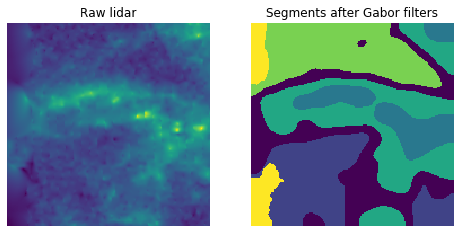

In [96]:
with open("Data/"+fid+"g_segments.txt", "r") as f:
	segmented = np.loadtxt(f)
with open(ls_lidar[ns[n]], 'r') as f:
    data = np.loadtxt(f)
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.imshow(data)
plt.axis(False)
plt.title("Raw lidar")
plt.subplot(122)
plt.axis(False)
plt.imshow(segmented)
plt.title("Segments after Gabor filters")

Now we will collate the statistics (skew, entropy) for the segments (contours)

In [97]:
seg_copy, seg_skew2, seg_entr2, merge_table = find_cnts(segmented, data)
seg_down = seg_copy.copy() #Create a duplicate for later use
xx, yy = np.meshgrid(np.arange(data.shape[1]) , np.arange(data.shape[0]))

Now we are ready to merge similar clusters using our predefined functions from above

In [98]:
seg_down, N = merge_clusters(segmented, data)
# N2 = N
Ns = [0,1]
total_count = 0
while True:
	seg_down, N = merge_clusters(seg_down, data)
	Ns.append(N)
	seg_down[np.where(seg_down==0)] = griddata((yy[np.where(seg_down!=0)].flatten(), xx[np.where(seg_down!=0)].flatten()), seg_down[np.where(seg_down!=0)].flatten(), np.where(seg_down==0), method='nearest')
	total_count+=1
	if Ns[-2]==Ns[-1] or total_count==100:
		break
if total_count>0:
    print("Merge completed")
#save segments
with open("Data/segments/"+str(ls_i[ns[n]])+"_segfin.txt" , 'w') as f:
	np.savetxt(f, seg_down)

Merge completed


Now let's look at the final segments

Text(0.5, 1.0, 'Final segments + snow depths')

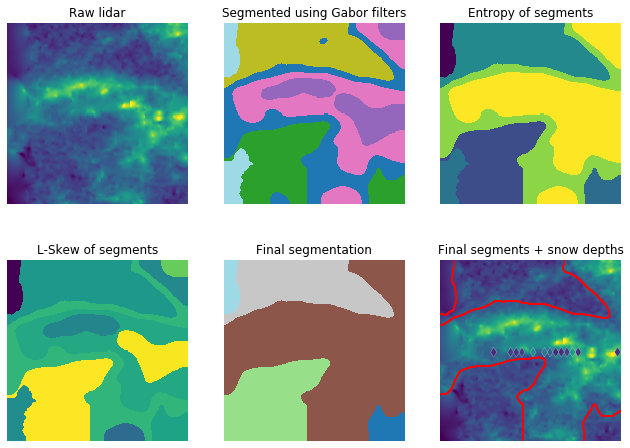

In [99]:
plt.figure(figsize=(11,8))
plt.subplot(231)
plt.axis('off')
plt.title("Raw lidar")
plt.imshow(data, vmin=0, vmax=2)
plt.subplot(232)
plt.axis('off')
plt.title("Segmented using Gabor filters")
# with open("/home/jeffrey/textureSegmentation/segments/"+fid+"g_segments.txt", "r") as f:
# 	segmented = np.loadtxt(f)
plt.imshow(segmented, cmap='tab20')
plt.subplot(233)
plt.axis('off')
plt.title("Entropy of segments")
plt.imshow(seg_entr2)
plt.subplot(234)
plt.axis('off')
plt.title("L-Skew of segments")
plt.imshow(seg_skew2)
plt.subplot(235)
plt.title("Final segmentation")
plt.axis('off')
count = 1
for i, val in enumerate(np.unique(seg_down)):
	seg_down[np.where(seg_down==val)] = count
	count+=1
plt.imshow(seg_down, cmap='tab20')
plt.subplot(236)
plt.imshow(data, vmin=0, vmax=2)
plt.axis('off')
try:
	with open(ls_txt[ns[n]], 'r') as f:
		snow = np.loadtxt(f)
	plt.scatter(snow.T[0], snow.T[1], c=snow.T[2], vmin=0, vmax=1, marker='d', s=50, ec='w', lw=0.2)
except:
	pass
edges = cv2.Canny(seg_down,1,2)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
# plt.imshow(data)
for i , cnt in enumerate(contours):
	plt.plot(cnt.T[0].flatten(), cnt.T[1].flatten(), c='r')
plt.title("Final segments + snow depths")

Now that we have the segments - we need to extrapolate the snow depths (the diamonds in the preceding figure) into those segments that have no snow depth.

First, compile the mean, std, entropy and L-Skew for all segments in our examples. Note that you have to run the above code for all files in the directory first.

In [128]:
def do_one(fid):
	'''
	compiles all the contour data for some fileID (fid)
	'''
	# fid = str(im_id).zfill(5)
	with open("Data/segments/"+fid+'_segfin.txt', 'r') as f:
		segs = np.loadtxt(f).astype('uint8')
	with open("Data/2010_1028_qfit_"+fid+"_lid_cnn.txt", 'r') as f:
		lidar = np.loadtxt(f)

	try:
		with open("Data/2010_1028_qfit_"+fid+"_snow.txt", 'r') as f:
			snowx, snowy, snowd = np.loadtxt(f, unpack=True, usecols=(0,1,2))
		# snowd*=0.79 #assumes snow density of 300 
		# This is already done in make_ib_cnn!!!
	except:
		snowx, snowy, snowd = np.array([]), np.array([]), []
	##correct segment id, fill small holes
	counter = 1
	for i , val in enumerate(np.unique(segs)):
		if np.sum(segs==val)<500:
			segs[segs==val] = 0
		else:
			segs[segs==val] = counter
			counter+=1
	xx, yy = np.meshgrid(np.arange(180) , np.arange(180))
	segs[np.where(segs==0)] = griddata((yy[np.where(segs!=0)].flatten(), xx[np.where(segs!=0)].flatten()), segs[np.where(segs!=0)].flatten(), np.where(segs==0), method='nearest')
	####
	if np.percentile(lidar, 99.99) > 5:
		print("Lidar too high "+fid)

	else:
		lidar[lidar>5]=5
		lidar[lidar<0]=0
		data_im = (lidar/5*255).astype('uint8')
		entr_img = entropy(data_im, disk(10))
		all_data = np.zeros((len(np.unique(segs)), 11))
		x000y = 1000*(snowx).astype('int')+(snowy).astype('int')
		for i , val in enumerate(np.unique(segs)): 
			datacut = lidar[segs==val]
			entr = np.mean(entr_img[segs==val])
			ratios = lmom.samlmu(datacut)
			kurt, skew = ratios[2], ratios[3]
			mean = np.mean(datacut)
			std = np.std(datacut)
			area = len(datacut)
			xxcut, yycut = xx[segs==val].flatten(), yy[segs==val].flatten()
			xx000yy= xxcut*1000+yycut
			snow_bool = np.isin(x000y, xx000yy)
			if np.sum(snow_bool)>0:
				snow_mean = np.mean(snowd[snow_bool==True])
				N = np.sum(snow_bool)

				##return mean lidar, and hence ratio
				snow_cnt = x000y[snow_bool==True]
				seek_x = np.floor(snow_cnt/1000).astype('int')
				seek_y = (snow_cnt - seek_x*1000).astype('int')
				meanratio = []
				for j in range(len(seek_x)):
					lidar_window = lidar[max(0, seek_y[j]-4):seek_y[j]+4, max(seek_x[j]-4,0):min(180, seek_x[j]+4)]
					lidar_mean = np.mean(lidar_window)
					lidar_max = np.max(lidar_window)
					# lidar_min = np.min(lidar_window)
					if np.isnan(lidar_mean) or np.isnan(lidar_max):
						continue
					ratio = lidar_mean/snowd[snow_bool==True][j] #whatif snowd = 0?
					meanratio.append(max(ratio,1))
				mean_ratio = hmean(meanratio)
			else:
				# continue
				snow_mean = np.nan
				N = np.nan
				mean_ratio = np.nan
			all_data[i] = np.array([int(fid), val, area, skew, kurt, entr, mean, std, snow_mean, N, mean_ratio])
		with open("Data/all_contour_data.txt", "a") as f:
			np.savetxt(f, all_data.reshape(-1, all_data.shape[1])) #add a catch in case only 1 row
	print("Done {}".format(fid))
	return
with open("Data/all_contour_data.txt", "w") as f:
    f.write("#fid val area LSkew LKurt entr mean std meansnow Nsnow meanratio\n")
for n in range(len(ns)):
    do_one(str(ls_i[ns[n]]))

Done 14484
Done 14606
Done 17619
Done 18287
Done 18296
Done 18303


Now we will switch over to pandas for easier table management. We will load our contour data as a dataframe:

In [129]:
df = pd.read_csv("Data/all_contour_data.txt", sep=' ')
df.head()
#Those columns of NaNs are what we are trying to extrapolate.

,#fid,val,area,LSkew,LKurt,entr,mean,std,meansnow,Nsnow,meanratio
0,14484.0,1.0,3045.0,0.112642,0.036394,3.818622,0.541072,0.070290,NaN,NaN,NaN
1,14484.0,2.0,3794.0,0.888306,0.954107,0.423235,0.004217,0.025881,NaN,NaN,NaN
2,14484.0,3.0,11995.0,0.287713,0.108524,3.787095,0.326232,0.119939,0.124859,3.0,2.610323
3,14484.0,4.0,1165.0,0.051056,0.026677,5.146753,0.656860,0.251424,NaN,NaN,NaN
4,14484.0,5.0,12401.0,0.107391,0.112581,5.072925,0.976744,0.362211,0.357630,7.0,2.359693


In [131]:
df_copy = df.copy() #create a copy for reference as we will overwrite df
#Let's try and extrapolate thoe snow depths that we already know, as a check that it works
true_inds = df.index[np.isfinite(df.Nsnow)]
true_snow = df_copy.loc[true_inds, ['mean', 'meansnow', 'meanratio', 'Nsnow']]
true_snow['scaledsnow'] = true_snow['mean']/true_snow.meanratio

Now we have to decide what metrics to use - set this in the next line.

In [1]:
comparisons = ['entr', 'LSkew', 'mean', 'std']

Now we will run the extrapolation over all the samples that have snow depths (true_inds) - note that not all samples will have a match, and in this case, the meanratio/meansnow values will appear as 'NaN'.

In [385]:
truths = np.ones(len(true_inds))
THRESH = 100000 #reduce this if you want to limit how local to search for matches
bad_ids = true_inds[truths==1] #these ones need completion

for bad_id in bad_ids:
    #slice
    df_one = df[df.index==bad_id]
    bad_fid = df_one['#fid'].values[0]
    #make targeted meansnow nan
    df.loc[bad_id, ['meansnow', 'meanratio']] = np.nan
    df_one = df[df.index==bad_id]
    df_bad = df_one.loc[np.isnan(df_one['meansnow'])]
    df_near = df_copy[np.abs(df_copy['#fid']-bad_fid)<=THRESH].dropna(thresh=11) #only take those that do have snow
    df_near = df_near[df_near.index!=bad_id] #exclude original. might be unnecessary.
    assert len(df_bad)==1
    if len(df_near)>0:
        for r in df_bad.itertuples():
            thr_new = 0.03
            local_comp = [r.entr, r.LSkew, r.mean, r.std]
            out = np.array([np.abs((df_near[comparisons[l]].values-local_comp[l])) for l in range(4)])
            gm = gmean(out+0.001, axis=0)
            while df_near[gm<thr_new].Nsnow.sum()<9 and thr_new<0.05:
                thr_new += 0.005
            df_pass = df_near[gm<thr_new]
            gm_pass = gm[gm<thr_new]
            total_gm = np.sum(gm_pass)
            df_passcut = df_pass[['Nsnow', 'meanratio']].T.values

            weights_N = df_passcut[0]/(gm_pass)#*df_pass['Nsnow'].values
            total_w = np.sum(weights_N)
            insert_mean = np.sum(weights_N*df_pass['meansnow'])/total_w
            #harmonic mean, weighted by similarity and number of measurements
            insert_ratio = total_w/(np.sum(weights_N/df_passcut[1]))
            insert_ratio/=0.97
            df.loc[r.Index, 'meansnow'] = insert_mean
            df.loc[r.Index, 'meanratio']= insert_ratio

            # df.loc[r.Index, 'Nsnow']= df_near[gm<thr_new].Nsnow.sum()
            truths[np.argwhere(true_inds==bad_id).flatten()[0]] = THRESH
            count+=1
    else:
        print("bad")

/home/jeffrey/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/home/jeffrey/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


Now we can see that some of the segments have been completed! e.g. #4 below

In [386]:
df.head()

,#fid,val,area,LSkew,LKurt,entr,mean,std,meansnow,Nsnow,meanratio
0,14484.0,1.0,3045.0,0.112642,0.036394,3.818622,0.541072,0.070290,NaN,NaN,NaN
1,14484.0,2.0,3794.0,0.888306,0.954107,0.423235,0.004217,0.025881,NaN,NaN,NaN
2,14484.0,3.0,11995.0,0.287713,0.108524,3.787095,0.326232,0.119939,NaN,3.0,NaN
3,14484.0,4.0,1165.0,0.051056,0.026677,5.146753,0.656860,0.251424,NaN,NaN,NaN
4,14484.0,5.0,12401.0,0.107391,0.112581,5.072925,0.976744,0.362211,0.480229,7.0,1.845373


In [153]:
true_snow['calc_snow'] = true_snow['mean']/(df.meanratio)

Now we can compare the true snow ('scaledsnow') with the extrapolated snow depth ('calc_snow') The error is quite high, but keep in mind that the real algorithm looks for matches within a much larger set of segments (within 10 km), and here we only have 6 lidar windows in total.

Text(0, 0.5, 'Predicted snow (m)')

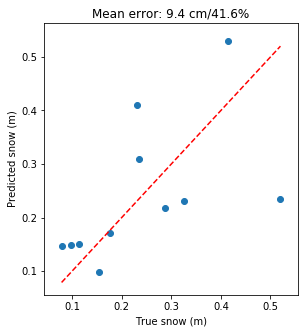

In [185]:
mae = np.abs(true_snow.scaledsnow-true_snow.calc_snow).mean() #mean absolute error
mre = (np.abs(true_snow.scaledsnow-true_snow.calc_snow)/true_snow.scaledsnow).mean()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(true_snow.scaledsnow, true_snow.calc_snow)
plt.title("Mean error: {:.1f} cm/{:.1f}%".format(mae*100, mre*100))
plt.plot([true_snow.scaledsnow.min(),true_snow.scaledsnow.max()],[true_snow.scaledsnow.min(),true_snow.scaledsnow.max()],'r--')
plt.xlabel("True snow (m)")
plt.ylabel("Predicted snow (m)")

Define some more functions. This is a bit of a hack, but to identify the matched segments we are just going to use the segment mean and assume it is unique. This is because the segment numbering is not saved.

In [327]:
def open_and_plot(fid):
    '''
    n is the index from the DataFrame
    '''
    with open("Data/2010_1028_qfit_{}_lid_cnn.txt".format(int(fid)), 'r') as f:
        lidar = np.loadtxt(f)
    with open("Data/segments/{}_segfin.txt".format(int(fid)), 'r') as f:
        segments = np.loadtxt(f).astype('uint8')
    plt.imshow(lidar)
    edges = cv2.Canny(segments,1,2)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    for i , cnt in enumerate(contours):
        color='r'
        plt.plot(cnt.T[0].flatten(), cnt.T[1].flatten(), c=color)
    mean_window = np.zeros_like(lidar)
    for i in np.unique(segments):
        mean_window[segments==i]=(np.mean(lidar[segments==i]))
    return mean_window

def find_matches(n):
    r = df_copy.iloc[n]
    local_comp = [r.entr, r.LSkew, r['mean'], r['std']]
    df_near = df_copy.loc[df.index!=n, ['entr', 'LSkew', 'mean', 'std', 'val', '#fid']]
    out = np.array([np.abs((df_near[comparisons[l]].values-local_comp[l])) for l in range(4)])
    gm = gmean(out+0.001, axis=0)
    thr_new = 0.055
    df_pass = df_near[gm<thr_new]
    return df_pass[['val', '#fid', 'mean']]
    

#These are the possible values that you can put for segment_id below

In [355]:
print(df.loc[df.meansnow>0].index)

Int64Index([4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20], dtype='int64')


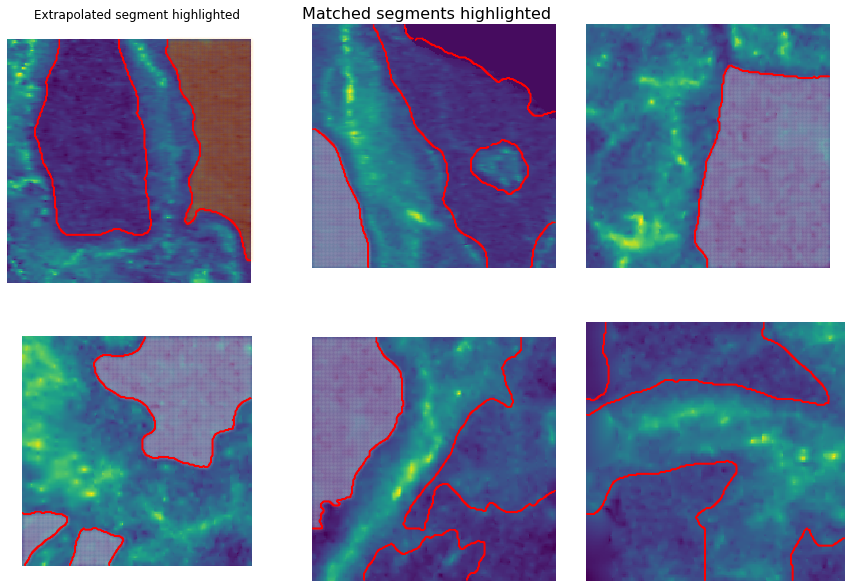

In [383]:
segment_id = 7 #you can change this!
#first, we show which segment is being matched
fid, val = df.loc[segment_id, ['#fid', 'val']]
plt.figure(figsize=(12,9))
plt.subplot(231)
mean_window = open_and_plot(fid)
y, x = np.where(np.round(mean_window,4)==np.round(df.loc[segment_id, 'mean'],4))
plt.scatter(x, y, c='orange', alpha=0.02)
plt.axis(False)
plt.title("Extrapolated segment highlighted")

#now, we find the matches and highlight them
vals, fids, means = find_matches(segment_id).values.T
other_fids = np.unique(df.loc[df['#fid']!=fid, '#fid'])
for j in range(1,6):
    plt.subplot(2,3,j+1)
    mean_window = np.round(open_and_plot(other_fids[j-1]), 4)
    if other_fids[j-1] in fids:
        for k in np.round(means, 4):
            y, x = np.where(mean_window==k)
            plt.scatter(x, y, c='w', alpha=0.02)
    if j==1:
        plt.title("Matched segments highlighted",size=16)
    plt.axis('off')
plt.tight_layout(w_pad=0.01, h_pad=0.01)

Here, we can see that the segment in orange (a relatively flat segment) is texturally matched to several other flat segments

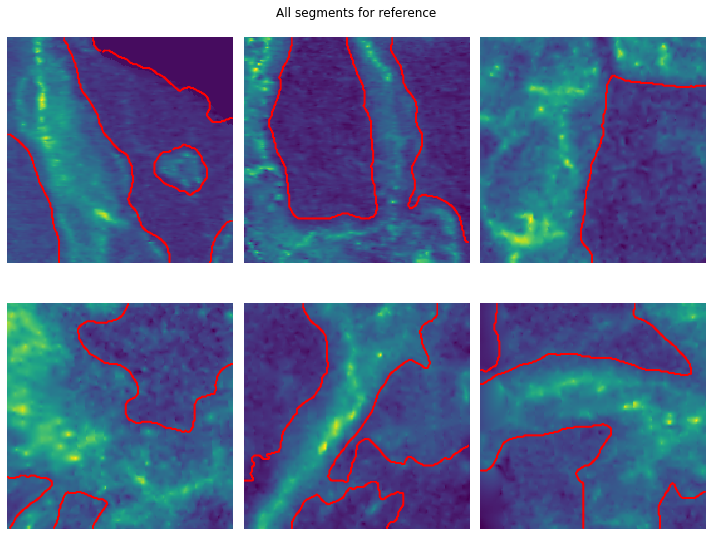

In [345]:
plt.figure(figsize=(10,8))
for j in range(1,7):
    plt.subplot(2,3,j)
    plt.axis('off')
    mean_window = np.round(open_and_plot(ls_i[j-1]), 4)
plt.suptitle("All segments for reference")
plt.tight_layout()